데이터 및 코드: https://github.com/datascienceabe/study_open/tree/master/A_B_testing/

# Bayesian Two sample Test 

참고: Stucchio, C. (2015). Bayesian A/B Testing at VWO. Whitepaper, Visual Website Optimizer.

데이터 출처: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/ab_testing

# 1. Binomial - Beta 

- 베이지안은 모수를 확률 변수로 보는 관점
- $X_{j}$: A,B 사이트에서 각각 광고를 클릭한 수
- $\theta_{j}$: A,B 사이트에서 각각 광고를 클릭할 확률

데이터의 분포: $X_{j}|\theta_{j} \sim Binomial(\theta_{j})$<br>
사전 분포: $\theta_{j}\sim Beta(\alpha_{j},\beta_{j})$<br>
사후 분포: $\theta_{j}|X_{j} \sim Beta(X_{j}+\alpha_{j},n-X_{j}+\beta_{j})$

- 사전 분포 Beta는 Binomial 분포의 Cojugate prior로 사후 분포를 쉽게 계산할 수 있음
- 데이터가 쌓일 수록 사전 분포의 힘은 약해짐

- 이제 Frequentist와 같은 가설을 수립할 필요가 없어 p-value를 안 구해도 됨
- $(\theta_{A},\theta_{B})$의 결합 분포를 구하면 A를 클릭할 확률이 B 보다 높을 확률 $P(\theta_{A}>\theta_{B})$을 계산할 수 있음

<b>Monte-Carlo Simulation</b><br>
$P(\theta_{A}>\theta_{B})$은 구할 수는 있지만 상당히 복잡하기 때문에 Monte-Carlo Integration을 통해 추정<br>
<br>
1) $\theta_{j}|X_{j} \sim Beta(X_{j}+\alpha_{j},n-X_{j}+\beta_{j})$<br>
: 사후 분포<br>
2) $\theta_{j}^{(1)},\theta_{j}^{(2)}, ...,\theta_{j}^{(t)} $<br>
: 사후 분포에서 $\theta$ 샘플링<br>
3) $\sum_{t}^{T} (\frac{I(\theta_{A}^{(t)}>\theta_{B}^{(t) })}{t}   ) ->p(\theta_{A}>\theta_{B})$<br>
: 샘플링 된 $\theta$의 함수를 통해 추정 (샘플링 수가 많아질 수록 수렴)

In [15]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/A_B_testing')
df=pd.read_csv('./data/advertisement_clicks.csv')

In [16]:
XA=df[df['advertisement_id']=='A']['action']
XB=df[df['advertisement_id']=='B']['action']

In [17]:
Na=XA.size
Nb=XB.size
Xa=XA.sum()
Xb=XB.sum()

In [18]:
import numpy as np
from scipy.stats import beta
np.random.seed(0)
a1= 1+Xa
b1= Na-Xa+1
a2= 1+Xb
b2= Nb-Xb+1

T=20000
thetaA=np.random.beta(a1, b1,T)
thetaB=np.random.beta(a2, b2,T)
print (np.mean(thetaA>thetaB)    )
print (np.mean(thetaA<thetaB)  )    

0.0003
0.9997


In [19]:
import matplotlib.pyplot as plt
plt.hist(thetaA, bins='auto')
plt.hist(thetaB, bins='auto')# arguments are passed to np.histogram
plt.title("Histogram with Advertisement A and B")
plt.show()

- 사전 분포에 대한 정보가 없기 때문에 $Beta(1,1)$의 Non-informative prior 사용
- B 광고를 더 클릭할 확률 $p(\theta_{A}<\theta_{B})=0.99$로 A 광고 보다 압도적으로 높음
- 왼쪽 파랑색은 A광고를 클릭할 확률의 분포 오른쪽은 B 광고를 클릭할 확률의 분포

# 2. Poisson - Gamma

참고:
- https://barnesanalytics.com/bayesian-poisson-ab-testing-in-pymc3-on-python

데이터 출처: 
- http://www.randomservices.org/random/

가정<br>
1) 한 구간 (짧은 시간) 동안 0번에서 최대 K번의 사건 발생<br>
2) 구간 간의 사건은 독립적<br>
3) 두 가지 사건은 동시에 일어 날 수 없음<br>
4) 사건의 발생이 매우 드뭄


각 집단에 대해<br>
데이터의 분포: $X_{1}...X_{n}|\lambda_{k}  \sim Poisson(\lambda)$<br>
사전 분포: $\lambda \sim Gamma(\alpha,\beta) $<br>
사후 분포: $\lambda_{k}|X_{1k}...X_{n_{k}k} \sim Gamma (\alpha+ \sum_{i} X_{i}, \beta+ n) $



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv('./data/HorseKicks.txt',sep='\t')

In [21]:
df.head()

,Year,GC,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C14,C15
0,1875,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,1876,2,0,0,0,1,0,0,0,0,0,0,0,1,1
2,1877,2,0,0,0,0,0,1,1,0,0,1,0,2,0
3,1878,1,2,2,1,1,0,0,0,0,0,1,0,1,0
4,1879,0,0,0,1,1,2,2,0,1,0,0,2,1,0


데이터<br>
- 매년 프러시아 경기병이 말 발차기에 죽은 숫자<br>
- 1875년 부터 1894년 (총 20년)<br>
- 호위대(GC)와 15개의 군단 (C1~C15) <br>

In [22]:
#preprocessing

df.index = df['Year']
df.drop(['Year'],1,inplace=True)
df=df.stack().reset_index()
df.columns = ['Year', 'Corps', 'Count']
df.dropna(inplace=True)
corps = df['Corps'].unique()
corps = pd.DataFrame(corps, columns=['Corps'])
corps['i'] = corps.index
df = pd.merge(df, corps, on=['Corps'], how='left')

In [23]:
df.head()

,Year,Corps,Count,i
0,1875,GC,0,0
1,1875,C1,0,1
2,1875,C2,0,2
3,1875,C3,0,3
4,1875,C4,0,4


In [24]:
N1=df[df.iloc[:,3]==12]['Count'].size
X1=df[df.iloc[:,3]==12]['Count'].sum()
N2=df[df.iloc[:,3]==11]['Count'].size
X2=df[df.iloc[:,3]==11]['Count'].sum()

<IPython.core.display.Javascript object>


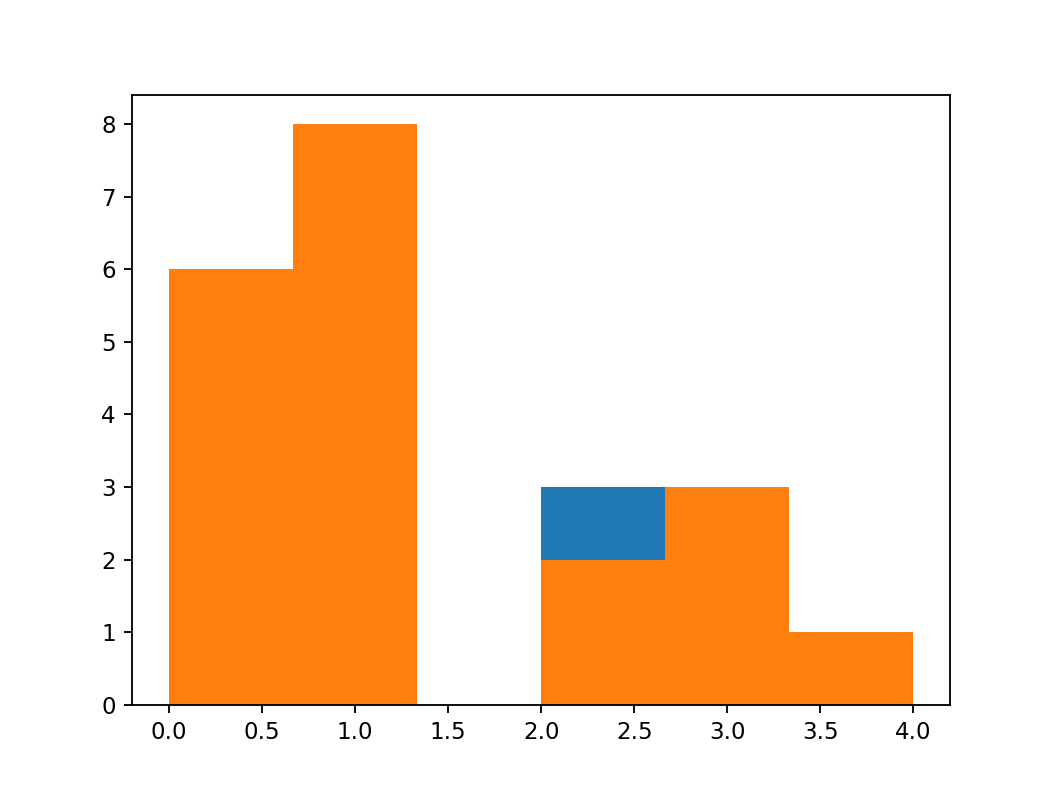

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(df[df.iloc[:,3]==12]['Count'], bins='auto')
plt.hist(df[df.iloc[:,3]==11]['Count'], bins='auto')
plt.show()

- 데이터가 횟 수에 대한 데이터이고
- 왼쪽으로 치우친 데이터이며 사건이 발생 안한 것보다 한번 발생한 횟수가 많음
- 또한 사고가 발생 안한 경우가 상당히 많음
- 이로 보아 포아송 분포를 따르는 것으로 보임

In [8]:
import numpy as np
np.random.seed(0)
T=100000
theta1=np.random.gamma(X1,N1,T)
theta2=np.random.gamma(X2,N2,T)

print(np.mean(theta1>theta2))

0.44676


C14가 C11보다 사고가 많이 발생할 확률은 0.44

<IPython.core.display.Javascript object>


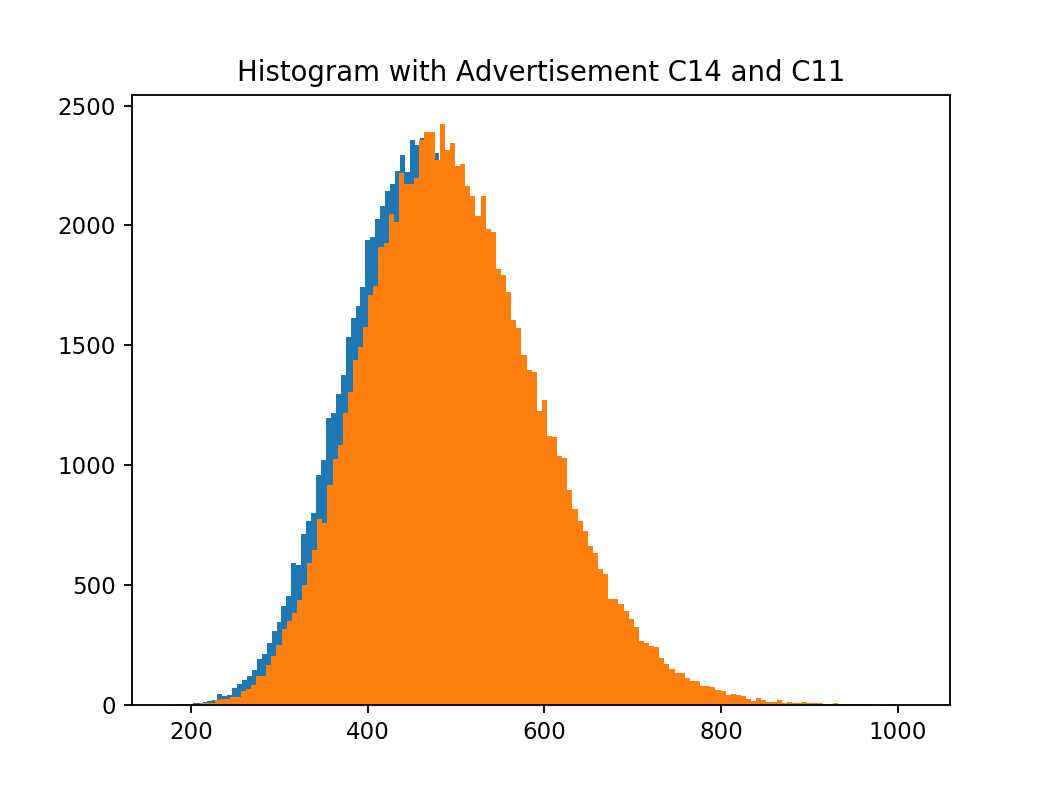

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(theta1, bins='auto')
plt.hist(theta2, bins='auto')# arguments are passed to np.histogram
plt.title("Histogram with Advertisement C14 and C11")
plt.show()

C11의 사후 분포가 약간 오른쪽에 있고 두 분포의 모양이 거의 비슷함

<IPython.core.display.Javascript object>


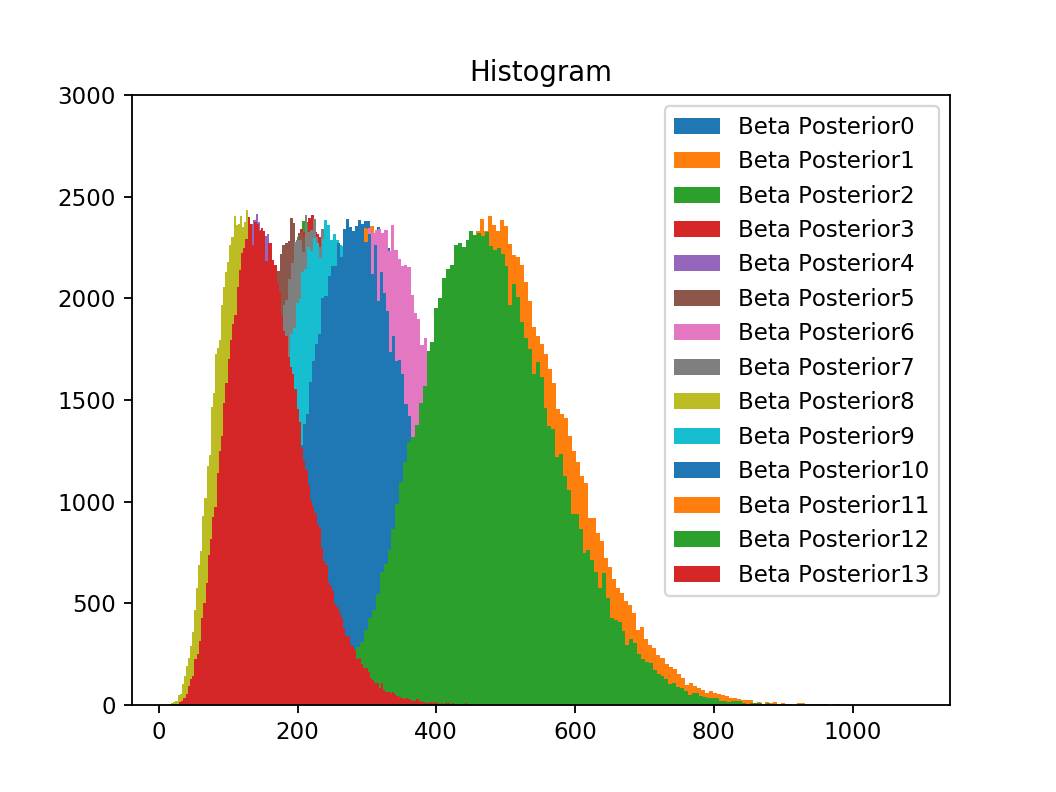

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

T=100000
THETA=[]

for i in range(14):

    N=df[df.iloc[:,3]==i]['Count'].size
    X=df[df.iloc[:,3]==i]['Count'].sum()
    theta=np.random.gamma(X,N,T)
    THETA.append(theta)
    plt.hist(theta, bins='auto', label='Beta Posterior'+str(i) )
    plt.ylim((0,3000))
    plt.legend()
    plt.title("Histogram")
    
plt.show()    

- 각 군단의 사고가 발생할 확률의 분포(사후분포)를 비교하면 C14(주황색)의 대부분이 맨 오른쪽에 있음
- C14의 사고 발생 확률이 가장 높음

# 3. Simulation

데이터가 얼마나 있어야 광고 간의 차이를 알 수 있을까?<br>
차이가 작아도 베이지안 방법으로 파악할 수 있을까?

:평균 클릭 수가 0.1인 집단과 0.11인 집단<br>
<br>
실험<br>
1) 1,2 집단에 대해 클릭 했는지 안했는지에 대한 2by2 contingency table을 만듦<br>
2) $u_{1},u_{2} \sim Uniform(0,1)$<br>
3) Uniform 분포에서 뽑은 $u_{1},u_{2}$가 평균보다 작으면 클릭을 한 것으로 카운트 (0.1, 011 확률로 클릭함)<br>
4) 클릭할 때마다 성공 횟수 혹은 실패 횟수 업데이터<br>
5) 1,2 집단의 사후 확률 업데이트 <br>
6) 2번 집단이 높을 확률 구함<br>

In [27]:
import numpy as np
from scipy.stats import beta
def B_win(a1,b1,a2,b2,T):

    thetaA=np.random.beta(a1, b1,T)
    thetaB=np.random.beta(a2, b2,T)
    return np.mean(thetaA<thetaB)  

In [28]:
p1=0.1
p2=0.11

#Click or not
u1=np.random.random() < p1
u2=np.random.random() < p2

<IPython.core.display.Javascript object>


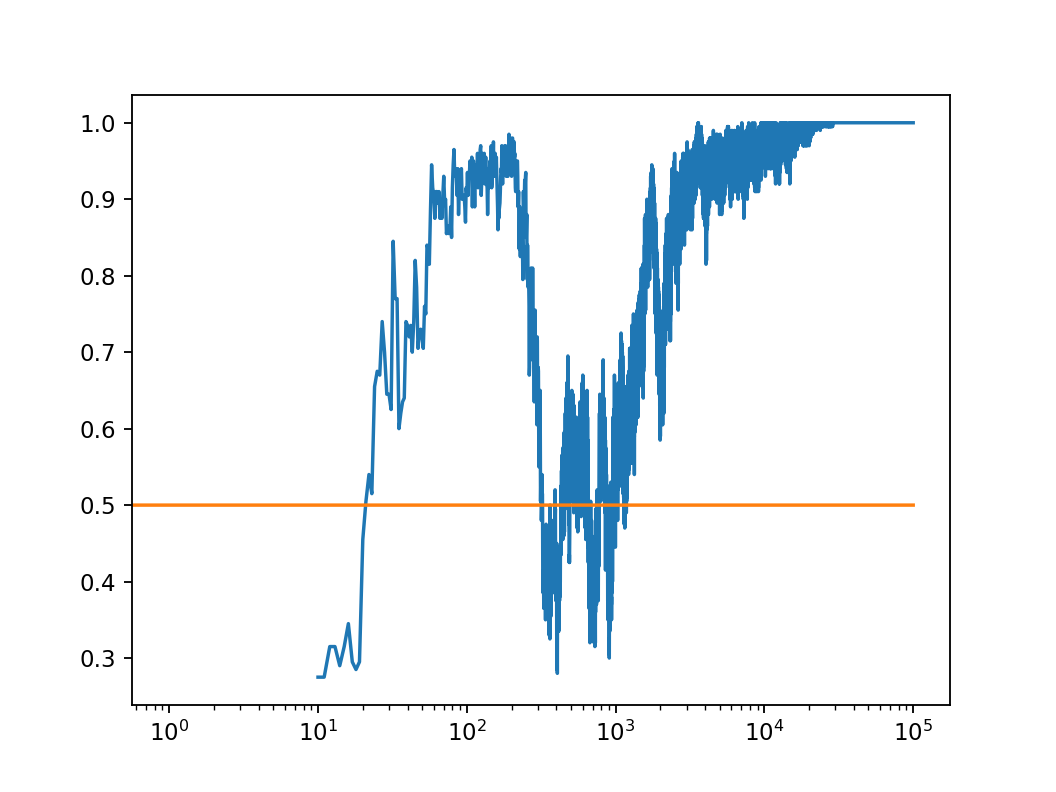

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
np.random.seed(0)
class DataGenerator:
  def __init__(self, p1, p2):
    self.p1 = p1
    self.p2 = p2

  def next(self):
    click1 = 1 if (np.random.random() < self.p1) else 0
    click2 = 1 if (np.random.random() < self.p2) else 0
    return click1, click2


def get_prob(T):
  
  a1= 1+T[0,1]
  b1= T[0,0]+1
  a2= 1+T[1,1]
  b2= T[1,0]+1
  p= B_win(a1,b1,a2,b2,200)  
    
  return p


def run_experiment(p1, p2, N):
  data = DataGenerator(p1, p2)
  p_values = np.empty(N)
  T = np.zeros((2, 2)).astype(np.float32)
  for i in range(N):
    c1, c2 = data.next()
    T[0,c1] += 1
    T[1,c2] += 1
    # ignore the first 10 values
    if i < 10:
      p_values[i] = None
    else:
      p_values[i] = get_prob(T)
  plt.plot(p_values)
  plt.plot(np.ones(N)*0.5)
  plt.xscale('log')
  plt.show()

run_experiment(0.1, 0.11, 100000)

- 약 700번 정도 클릭 했을 때 부터 2번의 확률이 계속 높아짐
- 만 번을 넘었을 때 부터는 안정적으로 2번의 확률이 높은 쪽으로 수렴<br>
<br>
- 일정 수의 데이터가 쌓이면 2번의 확률이 계속 높음
- 언제 테스트를 멈춰야 할지 알 수 있음

<b>Frequentist와의 연관성</b>

- X를 동전을 던졌을 때 앞면이 나올 확률이라고 하면 X는 Bernoulli 분포를 따름
- Frequentist에서는 데이터가 많아지면 CLT에 의해 $\bar{X}->N(0,1)$로 수렴함
- Bayesian에서 Uniform 사전 분포를 이용했을 때 사후 분포는 $\bar{X}$의 분포와 어떻게 차이가 날까? 

<IPython.core.display.Javascript object>


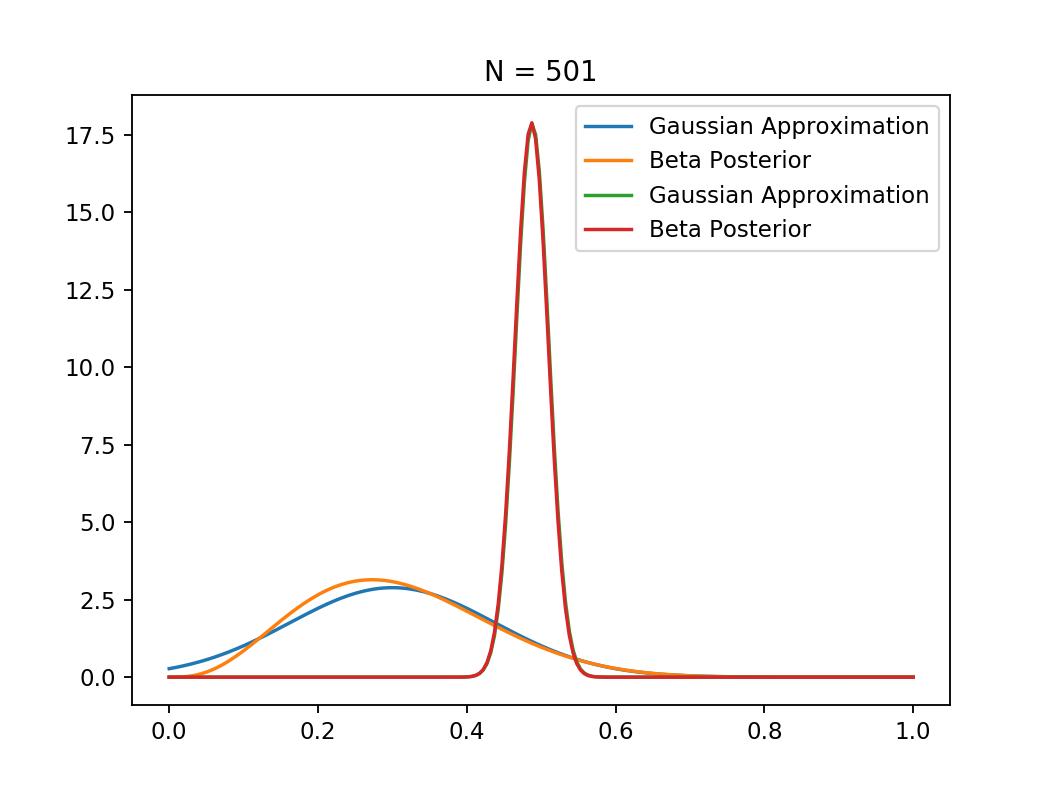

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, norm

T = 501 # number of coin tosses
true_ctr = 0.5
a, b = 1, 1 # beta priors
plot_indices = (10, 500)
data = np.empty(T)
for i in range(T):
  x = 1 if np.random.random() < true_ctr else 0
  data[i] = x

  # update a and b
  a += x
  b += 1 - x

  if i in plot_indices:
    # maximum likelihood estimate of ctr
    p = data[:i].mean()
    n = i + 1 # number of samples collected so far
    std = np.sqrt(p*(1-p)/n)
    
    # gaussian
    x = np.linspace(0, 1, 200)
    g = norm.pdf(x, loc=p, scale=std)
    plt.plot(x, g, label='Gaussian Approximation')

    # beta
    posterior = beta.pdf(x, a=a, b=b)
    plt.plot(x, posterior, label='Beta Posterior')
    plt.legend()
    plt.title("N = %s" % n)
    plt.show()

- 사후 분포가 데이터가 쌓일 수록 $\bar{X}$와 거의 일치하게 됨
- 데이터가 쌓일 수록 사전 분포의 힘이 약해지기 때문